In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_sales = pd.read_csv('SalesTransaction v.4a.csv')  # nama db/file

In [4]:
df_sales

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom
...,...,...,...,...,...,...,...,...
536345,C536548,12/1/2018,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany
536346,C536548,12/1/2018,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany
536347,C536548,12/1/2018,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany
536348,C536548,12/1/2018,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany


In [5]:
# jadikan semuanya timezone-aware UTC lalu buang timezone → dtype datetime64[ns]
df_sales['Date'] = (
    pd.to_datetime(df_sales['Date'], errors='coerce', dayfirst=True, utc=True)
      .dt.tz_localize(None)
)

# Lanjutkan dengan buang baris gagal parse (kalau ada), lalu cek:
df_sales = df_sales.loc[df_sales['Date'].notna()].copy()
print(df_sales['Date'].dtype)      # ➜ harus: datetime64[ns]
print(df_sales['Date'].head())

# Kalau mau memastikan tidak ada campuran timezone sebelum cast:
print(df_sales['Date'].map(lambda x: getattr(x, 'tz', None)).dropna().unique())


datetime64[ns]
0   2019-09-12
1   2019-09-12
2   2019-09-12
3   2019-09-12
4   2019-09-12
Name: Date, dtype: datetime64[ns]
[]


In [6]:
# Info kolom & tipe data
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230646 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  230646 non-null  object        
 1   Date           230646 non-null  datetime64[ns]
 2   ProductNo      230646 non-null  object        
 3   ProductName    230646 non-null  object        
 4   Price          230646 non-null  float64       
 5   Quantity       230646 non-null  int64         
 6   CustomerNo     230619 non-null  float64       
 7   Country        230646 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 15.8+ MB


# Data Cleansing
Saya sudah ganti code script dengan punya saya berikut:

In [7]:
# --- Bekerja di salinan aman
df_sales = df_sales.copy()

# === 1) PARSE SEKALI → Series `parsed` ===
s = df_sales['Date'].astype(str).str.strip()
is_serial = s.str.fullmatch(r'\d{5}(\.\d+)?')

# parse string (ubah dayfirst sesuai format datamu)
parsed = pd.to_datetime(s, dayfirst=True, errors='coerce')

# ganti bagian yang Excel-serial
serial_parsed = pd.to_datetime(s[is_serial].astype(float), unit='D', origin='1899-12-30')
parsed.loc[is_serial] = serial_parsed.values

# === 2) ASSIGN SEKALI & PAKSA dtype datetime64[ns] ===
df_sales.loc[:, 'Date'] = pd.DatetimeIndex(parsed)            # ini memaksa dt64[ns]
df_sales = df_sales.loc[df_sales['Date'].notna()].copy()      # buang yang gagal parse
df_sales.reset_index(drop=True, inplace=True)

print("Dtype Date ->", df_sales['Date'].dtype)  # harus datetime64[ns]


Dtype Date -> datetime64[ns]


# Top Contributing products

Pada retail store, ada banyak jenis barang yang dijual.
Memahami karakteristik penjualan di setiap barang sangatlah penting.  
Barang-barang dengan minat tinggi dari customer menjadi kunci bisnis untuk meraih untung.
Barang-barang dengan minat rendah dari masyarakat akan menjadi beban dari usaha apabila bisnis menyetok terlalu banyak.

Salah satu metode segmentasi yang digunakan adalah menggunakan segmentasi berdasarkan :
- Volume transaksi : Berapa banyak transaksi yang melibatkan suatu produk (Tidak mempedulikan banyaknya barang dalam 1 transaksi)
- Revenue total : Berapa dolar revenue yang dihasilkan dari penjualan produk ini.

Buatlah segmentasi produk berdasarkan volume dan revenue total dengan aturan sebagai berikut :

1. total_revenue didefinisikan sebagai perkalian harga barang dengan banyaknya pembelian
2. 20% produk dengan volume transaksi transaksi tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
3. 20% produk dengan total revenue tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
4. Berdasarkan penggabungan segmentasi no.2 dan no.3, apabila suatu produk Popular dari segi volume transaksi dan total revenue, maka segmentasi final dari produk tersebut adalah "Super Popular". Apabila salah satu atribut populer sementara atribut lainnya normal, maka segmentasi finalnya adalah "Popular". Apabila kedua atributnya "Low", maka segmentasi finalnya adalah "Low". Semua kombinasi lain selain yang disebutkan masuk ke kategori "Normal"

## Pertanyaan
1. Barang tipe apa yang masuk ke kategori super populer pada bulan November 2019?
2. Apakah barang yang populer di November 2019 sama dengan barang yang populer di Desember 2019?
3. Apakah barang yang masuk kategori super populer di november sama dengan barang super populer di July ?

In [8]:
try:
    df_sales
except NameError:
    raise NameError("df_sales belum ada. Muat dulu DataFrame penjualanmu.")

df_sales = df_sales.copy()
df_sales['Date'] = pd.to_datetime(df_sales['Date'], errors='coerce')
df_sales = df_sales[df_sales['Date'].notna()].copy()
if 'Revenue' not in df_sales.columns:
    df_sales['Revenue'] = df_sales['Price'] * df_sales['Quantity']

# ==== HELPERS ====
def month_df(df, year, month):
    per = pd.Period(f'{year}-{month:02d}', 'M')
    return df[df['Date'].dt.to_period('M') == per].copy()

def segment_products_month(df_month, top_pct=0.20, bottom_pct=0.20):
    g = (df_month.groupby(['ProductNo','ProductName'], as_index=False)
         .agg(Transaksi=('TransactionNo','nunique'),
              Volume=('Quantity','sum'),
              Revenue=('Revenue','sum')))
    r_trx = g['Transaksi'].rank(method='first', ascending=False, pct=True)
    r_rev = g['Revenue'].rank(method='first',  ascending=False, pct=True)

    def lbl(r):
        if r <= top_pct: return 'Popular'
        if r >= 1-bottom_pct: return 'Low'
        return 'Normal'
    g['Seg_Volume']  = r_trx.map(lbl)
    g['Seg_Revenue'] = r_rev.map(lbl)

    def final_seg(row):
        v, r = row['Seg_Volume'], row['Seg_Revenue']
        if v=='Low' or r=='Low':                 return 'Low'
        if v=='Popular' and r=='Popular':        return 'Super Popular'
        if {'Popular','Normal'} == {v, r}:       return 'Popular'
        return 'Normal'
    g['Segment'] = g.apply(final_seg, axis=1)
    return g

def show_sorted(df, title, top=10, by=('Revenue','Transaksi','Volume')):
    sort_cols = list(by) if isinstance(by,(list,tuple)) else [by]
    rev_alias = next((c for c in ('Revenue','Revenue_Month','Revenue_x','Revenue_y') if c in df.columns), None)
    mapped = []
    for c in sort_cols:
        if c=='Revenue' and rev_alias: mapped.append(rev_alias)
        elif c in df.columns:          mapped.append(c)
    if not mapped: raise KeyError(f"Kolom sort {sort_cols} tak ada. Kolom: {list(df.columns)}")
    df_sorted = df.sort_values(mapped, ascending=[False]*len(mapped), kind='mergesort').reset_index(drop=True)
    disp_rev = rev_alias if rev_alias else 'Revenue'
    cols = [c for c in ['ProductNo','ProductName','Transaksi','Volume',disp_rev,'Seg_Volume','Seg_Revenue','Segment'] if c in df_sorted.columns]
    print(f"\n=== {title} ===")
    print(df_sorted[cols].head(top).to_string(index=False))
    return df_sorted

# ==== RUN (Question 1 – Question 3) ====
seg_nov19 = segment_products_month(month_df(df_sales, 2019, 11))
seg_dec19 = segment_products_month(month_df(df_sales, 2019, 12))
seg_jul19 = segment_products_month(month_df(df_sales, 2019,  7))

# Question 1
super_nov_df = seg_nov19[seg_nov19['Segment']=='Super Popular']
show_sorted(super_nov_df, "Question 1 — Super Popular (Nov 2019) — urut Revenue↓", top=10)

# Question 2
popular_nov = set(seg_nov19.loc[seg_nov19['Segment']=='Popular','ProductNo'])
popular_dec = set(seg_dec19.loc[seg_dec19['Segment']=='Popular','ProductNo'])
print("\n=== Question 2 — Popular Nov 2019 vs Dec 2019 ===")
print("Sama?:", popular_nov == popular_dec)
show_sorted(seg_nov19[seg_nov19['ProductNo'].isin(popular_nov - popular_dec)],
            "Hanya Popular di Nov — urut Revenue↓", top=10)
show_sorted(seg_dec19[seg_dec19['ProductNo'].isin(popular_dec - popular_nov)],
            "Hanya Popular di Dec — urut Revenue↓", top=10)

# Question 3
super_nov = set(seg_nov19.loc[seg_nov19['Segment']=='Super Popular','ProductNo'])
super_jul = set(seg_jul19.loc[seg_jul19['Segment']=='Super Popular','ProductNo'])
print("\n=== Question 3 — Super Popular Nov 2019 vs July 2019 ===")
print("Sama?:", super_nov == super_jul)
show_sorted(seg_nov19[seg_nov19['ProductNo'].isin(super_nov - super_jul)],
            "Hanya Super Popular di Nov — urut Revenue↓", top=10)
show_sorted(seg_jul19[seg_jul19['ProductNo'].isin(super_jul - super_nov)],
            "Hanya Super Popular di July — urut Revenue↓", top=10)


=== Question 1 — Super Popular (Nov 2019) — urut Revenue↓ ===
ProductNo                         ProductName  Transaksi  Volume  Revenue Seg_Volume Seg_Revenue       Segment
    23084                  Rabbit Night Light        185    4836 61592.50    Popular     Popular Super Popular
    22197                      Popcorn Holder         87    4646 53781.92    Popular     Popular Super Popular
    22086      Paper Chain Kit 50'S Christmas        131    2895 40301.69    Popular     Popular Super Popular
    21915                Red Harmonica In Box         45    3259 37697.49    Popular     Popular Super Popular
    84879       Assorted Colour Bird Ornament         76    2540 30126.32    Popular     Popular Super Popular
   85123A  Cream Hanging Heart T-Light Holder         91    2082 27848.16    Popular     Popular Super Popular
    22578  Wooden Star Christmas Scandinavian         90    2061 21838.11    Popular     Popular Super Popular
    22492              Mini Paint Set Vintage    

,ProductNo,ProductName,Transaksi,Volume,Revenue,Seg_Volume,Seg_Revenue,Segment
0,15036,Assorted Colours Silk Fan,22,2106,23202.38,Popular,Popular,Super Popular
1,84992,72 Sweetheart Fairy Cake Cases,13,1541,16443.65,Popular,Popular,Super Popular
2,48187,Doormat New England,17,570,8704.53,Popular,Popular,Super Popular
3,21523,Doormat Fancy Font Home Sweet Home,16,544,8339.65,Popular,Popular,Super Popular
4,84755,Colour Glass T-Light Holder Hanging,24,696,7560.00,Popular,Popular,Super Popular
...,...,...,...,...,...,...,...,...
139,22333,Retrospot Party Bag + Sticker Set,15,77,924.90,Popular,Popular,Super Popular
140,23148,Miniature Antique Rose Hook Ivory,15,82,921.89,Popular,Popular,Super Popular
141,21155,Red Retrospot Peg Bag,14,64,899.61,Popular,Popular,Super Popular
142,22488,Natural Slate Rectangle Chalkboard,17,72,891.60,Popular,Popular,Super Popular


# Retention Cohort Analysis

Analisis kohort adalah metode analisis yang digunakan untuk mempelajari perilaku konsumen atau pengguna dari kelompok yang sama dalam periode waktu tertentu.   
Contoh Kohort : Kohort kustomer yang bergabung pada bulan mei

Analisis retensi adalah analisis untuk melihat seberapa besar persentase pengguna atau pelanggan yang kembali menggunakan produk atau layanan dalam periode waktu tertentu.

Dengan menganalisis kohort dan retensi, perusahaan atau organisasi dapat mengidentifikasi tren dan pola dalam perilaku pengguna atau pelanggan.

Berikut cuplikan matriks retensi yang akan kalian hasilkan pada bagian ini : 

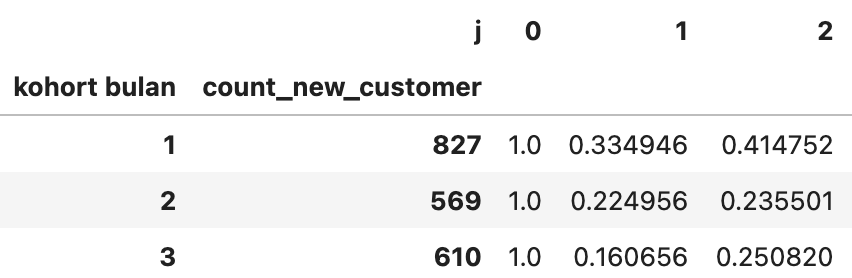

Cara baca :  
Pada bulan januari, ada 827 customer baru.  
33% dari 827 customer melakukan transaksi 1 bulan kemudian.  
41.4% dari 827 customer melakukan transasksi 2 bulan kemdian.  

Hal ini menunjukkan bahwa sekitar sepertiga customer yang melanjutkan transaksi setelah mendaftar pada bulan januari.  

Sedangkan pada kohort bulan februari, ada 569 customer baru dan hanya 22% customer yang kembali bertransaksi sebulan setelahnya  

Buatlah matriks kohort retensi per bulan menggunakan data dari 1 januari 2019 hingga 30 november 2019
Petunjuk : 
1. Hitung tanggal berapa transaksi pertama customer. Disini kita menggunakna asumsi bahwa transaksi pertama pada tahun 2019 adalah transaksi pertama customer.
2. Lakukan iterasi untuk setiap bulan. Ambil berapa banyak customer yang mendaftar dan berapa banyak customer yang sama yang melakukan transaksi di bulan bulan berikutnya.

## Pertanyaan
1. Bagaimana karakteristik pertumbuhan customer baru? Apakah pertumbuhan terus meningkat atau melambat?

2. Setiap bulannya tim marketing menggunakan metode promosi campaign yang berbeda-beda. Bulan mana yang menghasilkan retention paling tinggi?

In [9]:
# ===== 0) Siapkan data 2019 Jan–Nov =====
df19 = (
    df_sales.loc[(df_sales['Date'] >= '2019-01-01') & (df_sales['Date'] <= '2019-11-30')]
            .copy()
)

# guard: customer harus ada
df19 = df19.loc[df19['CustomerNo'].notna()].copy()

# Bulan transaksi (period bulanan)
df19['order_month'] = df19['Date'].dt.to_period('M')

# Cohort = bulan transaksi pertama customer di tahun 2019
first_month_2019 = (
    df19.groupby('CustomerNo', as_index=False)['order_month']
        .min()
        .rename(columns={'order_month':'cohort_month'})
)
df19 = df19.merge(first_month_2019, on='CustomerNo', how='left')

# Jarak bulan j = (order_month - cohort_month) dalam satuan bulan
df19['j'] = (df19['order_month'] - df19['cohort_month']).apply(lambda x: x.n)

# ===== 1) Matriks retensi (count & rate) =====
# hitung unique customer per (cohort_month, j)
ret_counts = (
    df19.groupby(['cohort_month','j'])['CustomerNo']
        .nunique()
        .unstack('j')                                # kolom j = 0,1,2,...
        .sort_index()
        .fillna(0).astype(int)
)

# cohort size (jumlah customer baru)
cohort_size = ret_counts.get(0, pd.Series(dtype=int)).rename('count_new_customer')

# retensi (rate) = bagi tiap kolom j dengan cohort_size
ret_rate = (ret_counts.div(cohort_size, axis=0)).round(6)      # 6 desimal biar rapi

# gabungkan: count_new_customer + matriks rate
cohort_table = pd.concat([cohort_size, ret_rate], axis=1)

# Tambahkan kolom bantu "kohort_bulan" (angka 1..12) agar sesuai contoh
cohort_table.index.name = 'cohort_month'
cohort_table = cohort_table.reset_index()
cohort_table['kohort_bulan'] = cohort_table['cohort_month'].dt.month
cohort_table = (
    cohort_table
      .set_index('kohort_bulan')
      .drop(columns=['cohort_month'])
      .sort_index()
)

print("\n=== MATRiks Retensi (Jan–Nov 2019) ===")
print(cohort_table.head(12).to_string())

# ===== 2) Jawaban Pertanyaan =====

# Q1. Karakteristik pertumbuhan customer baru (tren cohort size)
sizes = cohort_table['count_new_customer']
sizes = sizes.loc[sizes.index.sort_values()]  # pastikan urut bulan

first_val = int(sizes.iloc[0]) if len(sizes) else 0
last_val  = int(sizes.iloc[-1]) if len(sizes) else 0
mom_growth = sizes.pct_change().replace([np.inf, -np.inf], np.nan) * 100
avg_mom = float(mom_growth.dropna().mean()) if mom_growth.dropna().size else 0.0

trend_label = "meningkat" if (last_val > first_val and avg_mom > 0) else "melambat/menurun"

print("\n=== JAWABAN QUESTION 1 — Pertumbuhan Customer Baru ===")
print(f"- Jumlah cohort size bulan pertama: {first_val:,}")
print(f"- Jumlah cohort size bulan terakhir: {last_val:,}")
print(f"- Rata-rata pertumbuhan CAGR : {avg_mom:.2f}%")
print(f"- Kesimpulan: pertumbuhan {trend_label} berdasarkan perubahan awal→akhir dan rata-rata MoM.")

# Q2. Bulan dengan retention paling tinggi
# Kita evaluasi untuk j=1 (retur 1 bulan setelah join) dan j=2 (2 bulan setelah join).
best_j1_month = None; best_j1_val = None
best_j2_month = None; best_j2_val = None

if 1 in cohort_table.columns:
    idx1 = cohort_table[1].idxmax()
    best_j1_month = int(idx1)
    best_j1_val   = float(cohort_table.loc[idx1, 1])
if 2 in cohort_table.columns:
    idx2 = cohort_table[2].idxmax()
    best_j2_month = int(idx2)
    best_j2_val   = float(cohort_table.loc[idx2, 2])

print("\n=== JAWABAN QUESTION 2 — Bulan dengan Retention Tertinggi ===")
if best_j1_month is not None:
    print(f"- Retensi j=1 tertinggi: cohort bulan {best_j1_month} dengan rate {best_j1_val:.3f}")
else:
    print("- Kolom j=1 tidak tersedia pada data ini.")
if best_j2_month is not None:
    print(f"- Retensi j=2 tertinggi: cohort bulan {best_j2_month} dengan rate {best_j2_val:.3f}")
else:
    print("- Kolom j=2 tidak tersedia pada data ini.")

# (Opsional) Skor keseluruhan retention per cohort = average dari j>=1 yang tersedia
rate_cols = [c for c in cohort_table.columns if isinstance(c, (int, np.integer)) and c >= 1]
if rate_cols:
    cohort_table['avg_retention_(>=j1)'] = cohort_table[rate_cols].mean(axis=1)
    best_overall_idx = cohort_table['avg_retention_(>=j1)'].idxmax()
    print(f"- Rata-rata retention (j>=1) terbaik: cohort bulan {int(best_overall_idx)} "
          f"dengan rata-rata {cohort_table.loc[best_overall_idx,'avg_retention_(>=j1)']:.3f}")

# ===== 3) (Opsional) Format seperti contoh (hanya j=0..2) =====
cols_show = ['count_new_customer'] + [c for c in [0,1,2] if c in cohort_table.columns]
print("\n=== Cuplikan (format contoh: count_new_customer + j=0..2) ===")
print(cohort_table[cols_show].head(12).to_string())

#CAGR= CAGR, yaitu pertumbuhan rata-rata bulanan secara kompaun.
# Apa yang dilakukan script
# Menetapkan cohort bulan tiap customer (transaksi pertama di 2019).
# Menghitung retensi per j (bulan ke-0,1,2,… setelah bergabung) berbasis count unique customer yang bertransaksi.
# Membentuk tabel seperti contoh: count_new_customer + kolom j.
# Q1: Menganalisis tren pertumbuhan cohort size (awal vs akhir & rata-rata MoM).
# Q2: Menentukan bulan dengan retensi tertinggi untuk j=1 dan j=2, plus opsi skor rata-rata (≥j1).

# Kalau mau diexport ke Excel/CSV tinggal tambah:
# cohort_table.to_csv('cohort_retention_2019.csv', index=True)



=== MATRiks Retensi (Jan–Nov 2019) ===
              count_new_customer    0         1         2         3         4         5         6         7         8         9        10
kohort_bulan                                                                                                                             
1                            365  1.0  0.276712  0.279452  0.238356  0.301370  0.293151  0.241096  0.249315  0.257534  0.282192  0.334247
2                            316  1.0  0.142405  0.167722  0.183544  0.158228  0.151899  0.174051  0.215190  0.193038  0.240506  0.000000
3                            337  1.0  0.124629  0.189911  0.157270  0.139466  0.139466  0.189911  0.148368  0.213650  0.000000  0.000000
4                            314  1.0  0.162420  0.143312  0.156051  0.178344  0.136943  0.184713  0.187898  0.000000  0.000000  0.000000
5                            318  1.0  0.185535  0.106918  0.144654  0.122642  0.172956  0.160377  0.000000  0.000000  0.000000  0.0

# Time Series Analysis

Time series analysis adalah analisis untuk melihat trend suatu fenomena berdasarkan waktu.

## Pertanyaan 

Pertanyaan 1 :  
Coba totalkan penjualan setiap barang per hari.   
Bagaimana trend penjualan? Apakah ada mengalami kenaikan, penurunan, atau stagnant.

Pertanyaan 2 :  
Lakukan analisis seasonality dengan melihat total order per harinya dari Senin hingga Minggu.  


In [20]:
# ====== Setup & guard ======
df = df_sales.copy()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.normalize()  # pastikan harian murni
df = df.loc[df['Date'].notna()].copy()

if 'Revenue' not in df.columns:
    df['Revenue'] = df['Price'] * df['Quantity']

# ============================================================
# PERTANYAAN 1 — Total penjualan setiap barang per hari + trend
# ============================================================

# a) Total per item per hari
daily_product = (
    df.groupby(['Date','ProductNo','ProductName'], as_index=False)
      .agg(Quantity=('Quantity','sum'),
           Revenue =('Revenue','sum'),
           Orders  =('TransactionNo','nunique'))
)

# >>> Contoh yang benar: top-N produk SETIAP HARI (bukan 1 hari saja)
TOP_N_PER_DAY = 3        # ubah sesuai kebutuhan
N_HARI_SAMPLE = 5        # tampilkan 5 hari pertama sebagai contoh

top_per_day = (daily_product
               .sort_values(['Date','Revenue'], ascending=[True, False])
               .groupby('Date')
               .head(TOP_N_PER_DAY))

first_days = sorted(top_per_day['Date'].unique())[:N_HARI_SAMPLE]
print("\n=== Contoh: TOP produk per HARI ({} produk/ hari, {} hari pertama) ===".format(
    TOP_N_PER_DAY, N_HARI_SAMPLE))
print(top_per_day[top_per_day['Date'].isin(first_days)]
      .to_string(index=False))

# b) Total harian (semua produk digabung)
daily_totals = (
    df.groupby('Date', as_index=False)
      .agg(Revenue=('Revenue','sum'),
           Quantity=('Quantity','sum'),
           Orders=('TransactionNo','nunique'))
      .sort_values('Date')
)
print("\n=== Contoh total harian (5 baris teratas) ===")
print(daily_totals.head().to_string(index=False))

# c) Deteksi trend (berdasarkan Revenue harian)
trend_label = "data tidak cukup"
if len(daily_totals) >= 2:
    x = (daily_totals['Date'] - daily_totals['Date'].min()).dt.days.to_numpy()
    y = daily_totals['Revenue'].to_numpy(dtype=float)

    slope, _ = np.polyfit(x, y, 1)  # garis trend
    avg_rev = float(y.mean())
    total_change = float(slope * (x.max() - x.min()))
    pct_change = (total_change / avg_rev) if avg_rev != 0 else 0.0

    if pct_change > 0.05:
        trend_label = "meningkat"
    elif pct_change < -0.05:
        trend_label = "menurun"
    else:
        trend_label = "stagnan"

    print("\n=== Ringkas Trend Penjualan (Revenue harian) ===")
    print(f"Periode         : {daily_totals['Date'].min().date()} → {daily_totals['Date'].max().date()}")
    print(f"Rata2 revenue   : {avg_rev:,.2f}")
    print(f"Slope (per hari): {slope:,.2f}")
    print(f"Perkiraan Δtotal: {total_change:,.2f} ({pct_change*100:.2f}%)")
    print(f"Kesimpulan      : Trend {trend_label}")

# ============================================================
# PERTANYAAN 2 — Seasonality: total order per hari Senin–Minggu
# ============================================================

# Agregasi ke level hari
daily_orders = (
    df.groupby('Date', as_index=False)
      .agg(Orders=('TransactionNo','nunique'),
           Revenue=('Revenue','sum'))
)

# Hitung per weekday
weekday_num = daily_orders['Date'].dt.weekday  # 0=Senin..6=Minggu
group = (daily_orders
         .assign(weekday=weekday_num)
         .groupby('weekday', as_index=False)
         .agg(total_orders=('Orders','sum'),
              days=('Date','nunique'),
              total_revenue=('Revenue','sum')))

# reindex biar lengkap 0..6 lalu isi 0 agar tidak NaN
group = group.set_index('weekday').reindex(range(7), fill_value=0).reset_index()
group['avg_orders_per_hari']   = np.where(group['days']>0, group['total_orders']/group['days'], 0)
group['avg_revenue_per_hari']  = np.where(group['days']>0, group['total_revenue']/group['days'], 0)

hari_id = {0:'Senin',1:'Selasa',2:'Rabu',3:'Kamis',4:'Jumat',5:'Sabtu',6:'Minggu'}
weekday_stats = (group.assign(Hari=group['weekday'].map(hari_id))
                 [['Hari','total_orders','days','avg_orders_per_hari','total_revenue','avg_revenue_per_hari']]
                 .set_index('Hari'))

print("\n=== Seasonality — Total/Avg Orders & Revenue per Hari (Senin–Minggu) ===")
print(weekday_stats.round(2).to_string())

best_day_orders  = weekday_stats['avg_orders_per_hari'].idxmax()
best_day_revenue = weekday_stats['avg_revenue_per_hari'].idxmax()
print(f"\nHari dengan rata-rata ORDER tertinggi : {best_day_orders} "
      f"({weekday_stats.loc[best_day_orders,'avg_orders_per_hari']:.2f} order/hari)")
print(f"Hari dengan rata-rata REVENUE tertinggi: {best_day_revenue} "
      f"({weekday_stats.loc[best_day_revenue,'avg_revenue_per_hari']:,.2f} per hari)")


=== Contoh: TOP produk per HARI (3 produk/ hari, 5 hari pertama) ===
      Date ProductNo                        ProductName  Quantity  Revenue  Orders
2018-12-01     21137           Black Record Cover Frame       540  7408.80       2
2018-12-01    84029E      Red Woolly Hottie White Heart       551  7357.95      14
2018-12-01     21232     Strawberry Ceramic Trinket Pot       549  6300.54       8
2018-12-02     84077  World War 2 Gliders Asstd Designs      3264 34066.56       4
2018-12-02     84950     Assorted Colour T-Light Holder      1824 19717.44       1
2018-12-02     21915               Red Harmonica In Box      1448 16429.44       4
2018-12-03    17084R              Assorted Incense Pack      1440 14990.40       1
2018-12-03     22423           Regency Cakestand 3 Tier       231  5643.46      10
2018-12-03     71477 Coloured Glass Star T-Light Holder       313  4095.03       3
2018-12-05     17003                 Brocade Ring Purse       723  7526.61       2
2018-12-05     21

# Price Elasticity

Price sensitivity atau sensitifitas harga mengacu pada perubahan permintaan pelanggan akibat naik atau turunya harga suatu produk.

Pada bagian ini anda akan diminta untuk melakukan analisis terhadap suatu produk yang penjualannya sangat dipengaruhi oleh harga.

## Pertanyaan

Pertanyaan 1 :   
Produk apa yang paling sering mengalami perubahan harga?   
Hitunglah banyaknya harga unik di setiap produk dan ambil daftar produk yang pernah terjual dengan setidaknya 10 variasi harga yang berbeda.

Price Elasticity akan semakin baik dianalisis ketika lebih banyak variasi harga yang muncul.

Pertanyaan 2 :   
Dari semua produk yang terambil dari step 1, hitung lah korelasi antara harga dengan quantity untuk setiap barang.  
Barang manakah yang memiliki korelasi paling negatif?  

Pertanyaan 3 : 
Buatlah scatter plot antara harga dan quantity untuk barang dari soal sebelumnya.  
Apabila produk tersebut mengalami kenaikan harga, kira-kira apa yang akan terjadi dengan penjualan ?


=== Question 1 — Produk dengan ≥10 variasi harga unik ===
Jumlah produk kandidat: 288
ProductNo                        ProductName  n_unique_price
    22616          Pack Of 12 London Tissues              17
    82484  Wood Black Board Ant White Finish              17
    47566                      Party Bunting              16
    21481         Fawn Blue Hot Water Bottle              16
    21175      Gin And Tonic Diet Metal Sign              15
    20685              Doormat Red Retrospot              15
    22114  Hot Water Bottle Tea And Sympathy              15
    21931             Jumbo Storage Bag Suki              15
    21523 Doormat Fancy Font Home Sweet Home              15
    10133       Colouring Pencils Brown Tube              15
   84029E      Red Woolly Hottie White Heart              15
    22835    Hot Water Bottle I Am So Poorly              15
    21166          Cook With Wine Metal Sign              15
    22469              Heart Of Wicker Small              1

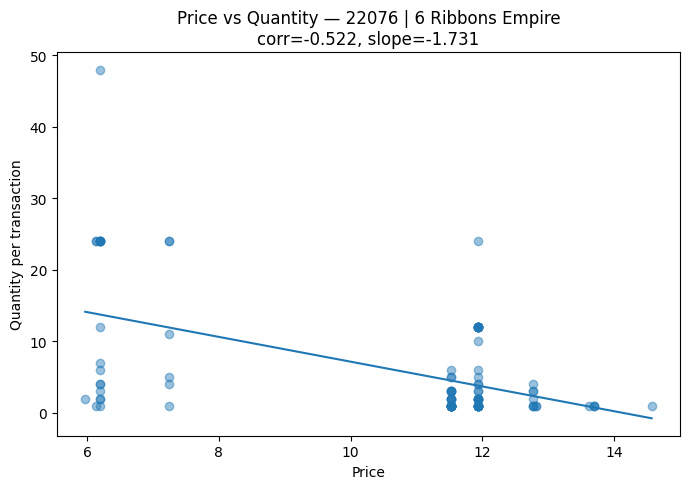


=== Question 3 — Interpretasi ===
Untuk produk 22076 — 6 Ribbons Empire, hubungan harga-qty negatif (corr=-0.522).
Estimasi: setiap kenaikan harga 1 unit, rata-rata quantity akan turun sekitar 1.731 unit (berdasarkan slope regresi linier).


In [21]:
# ----------------- Guard & data dasar -----------------
df = df_sales.copy()
# buang baris tidak valid jika ada
df = df[['ProductNo','ProductName','Price','Quantity','TransactionNo']].dropna()
# pastikan numerik
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df = df.dropna()

# ================= Q1. Produk dengan variasi harga terbanyak =================
price_var = (
    df.groupby(['ProductNo','ProductName'], as_index=False)['Price']
      .nunique()
      .rename(columns={'Price':'n_unique_price'})
      .sort_values('n_unique_price', ascending=False)
)

candidates = price_var.query('n_unique_price >= 10').reset_index(drop=True)

print("\n=== Question 1 — Produk dengan ≥10 variasi harga unik ===")
print(f"Jumlah produk kandidat: {len(candidates)}")
print(candidates.head(20).to_string(index=False))

# ================= Q2. Korelasi Harga vs Quantity (produk kandidat) =================
def corr_price_qty(g):
    # jika variasi price/qty terlalu sedikit → NaN
    if g['Price'].nunique() < 2 or g['Quantity'].nunique() < 2 or len(g) < 5:
        return pd.Series({'corr': np.nan, 'n_obs': len(g), 'slope_qty_per_price': np.nan})
    corr = g['Price'].corr(g['Quantity'])  # Pearson correlation
    # slope regresi (y=Quantity, x=Price)
    x = g['Price'].to_numpy(float)
    y = g['Quantity'].to_numpy(float)
    slope = np.polyfit(x, y, 1)[0]
    return pd.Series({'corr': corr, 'n_obs': len(g), 'slope_qty_per_price': slope})

corr_df = (
    df.merge(candidates[['ProductNo','ProductName']], on=['ProductNo','ProductName'], how='inner')
      .groupby(['ProductNo','ProductName'])
      .apply(corr_price_qty)
      .reset_index()
)

# urut dari korelasi paling negatif
corr_rank = corr_df.sort_values('corr', ascending=True)

print("\n=== Question 2 — Korelasi Harga vs Quantity (produk kandidat) ===")
print(corr_rank.head(10).to_string(index=False))

# ambil produk dengan korelasi paling negatif (abaikan NaN)
best_row = corr_rank.dropna(subset=['corr']).iloc[0]
best_prod_no   = best_row['ProductNo']
best_prod_name = best_row['ProductName']
best_corr      = best_row['corr']
best_slope     = best_row['slope_qty_per_price']
best_n         = int(best_row['n_obs'])

print(f"\nProduk dengan korelasi paling negatif: {best_prod_no} — {best_prod_name}")
print(f"Korelasi: {best_corr:.3f} | n: {best_n} | Slope Qty/Price: {best_slope:.3f}")

# ================= Q3. Scatter plot + interpretasi =================
prod_df = df[df['ProductNo'] == best_prod_no].copy()

plt.figure(figsize=(7,5))
plt.scatter(prod_df['Price'], prod_df['Quantity'], alpha=0.45)
m, b = np.polyfit(prod_df['Price'].to_numpy(float), prod_df['Quantity'].to_numpy(float), 1)
xline = np.linspace(prod_df['Price'].min(), prod_df['Price'].max(), 100)
plt.plot(xline, m*xline + b)
plt.xlabel('Price')
plt.ylabel('Quantity per transaction')
plt.title(f'Price vs Quantity — {best_prod_no} | {best_prod_name}\n'
          f'corr={best_corr:.3f}, slope={m:.3f}')
plt.tight_layout()
plt.show()

# Interpretasi (teks)
direction = "turun" if m < 0 else ("naik" if m > 0 else "tidak berubah")
print("\n=== Question 3 — Interpretasi ===")
print(f"Untuk produk {best_prod_no} — {best_prod_name}, hubungan harga-qty negatif (corr={best_corr:.3f}).")
print(f"Estimasi: setiap kenaikan harga 1 unit, rata-rata quantity akan {direction} sekitar {abs(m):.3f} unit "
      f"(berdasarkan slope regresi linier).")

Catatan:
- n_unique_price >= 10 mengikuti syarat pada soal. Ubah angkanya bila ingin ambang lain.
- corr adalah Pearson correlation; nilai paling kecil (paling negatif) berarti permintaan paling sensitif terhadap kenaikan harga.
- slope_qty_per_price memberi perkiraan perubahan rata-rata quantity untuk setiap +1 unit harga (dipakai untuk interpretasi Q3).

# Basket Size Analysis

Ketika seorang pelanggan e-commerce menekan "add to cart", maka barang tersebut akan disimpan dalam sebuah "basket".  
Ketika melakukan checkout, maka semua barang dalam basket tersebut akan diproses dan dikirimkan.  
Ukuran dari basket dapat diukur melalui nilai GMV (Gross merchandise volume) yang merupakan total harga barang yang dibeli.  
Contoh : 
Pada tanggal 1 januari 2012
Tuan A membeli 1 shampoo seharga 15ribu dan 2 sabun seharga 20ribu masing-masing. Maka basket size tuan A adalah 55ribu rupiah.
Nyonya B hanya membeli 1 cemilan seharga 20 ribu, maka basket size dari nyonya B adalah 20 ribu rupiah.
Berarti total GMV ecommerce pada 1 januari 2012 adalah 75ribu rupiah, dengan rata-rata basket size sebesar 37.5 ribu rupiah per basket.

## Pertanyaan
1. Hitung rata-rata basket size dari seluruh transaksi per harinya, apakah konsisten atau ada perubahan ?
2. Apakah ada perbedaan ukuran basket dari negara yang berbeda ?

In [22]:
# =============== Setup & Guard ===============
df = df_sales.copy()

# Pastikan tanggal harian (tanpa jam) dan nilai numerik
df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.normalize()
df = df.loc[df['Date'].notna()].copy()
df['Price']    = pd.to_numeric(df['Price'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df = df.dropna(subset=['Price','Quantity'])

# GMV baris & Country rapi
df['Revenue'] = df['Price'] * df['Quantity']
df['Country'] = df['Country'].astype(str).str.strip()

# ================== Level Transaksi (Basket) ==================
# Basket = 1 transaksi pada suatu tanggal & negara
tx = (df.groupby(['Date','TransactionNo','Country'], as_index=False)
        .agg(Basket_GMV=('Revenue','sum'),
             Items=('Quantity','sum')))

# ================== PERTANYAAN 1 ==================
# Rata-rata basket size dari seluruh transaksi per hari
daily = (tx.groupby('Date', as_index=False)
           .agg(avg_basket=('Basket_GMV','mean'),
                baskets=('TransactionNo','count'),
                total_gmv=('Basket_GMV','sum'),
                total_items=('Items','sum')))
daily = daily.sort_values('Date').reset_index(drop=True)

print("\n=== Contoh hasil harian (5 baris pertama) ===")
print(daily.head().to_string(index=False))

# Ringkas tren basket size harian (berdasarkan rata-rata basket per hari)
trend_label = "data tidak cukup"
if len(daily) >= 2:
    x = (daily['Date'] - daily['Date'].min()).dt.days.to_numpy()
    y = daily['avg_basket'].astype(float).to_numpy()
    slope, intercept = np.polyfit(x, y, 1)
    change_abs = slope * (x.max() - x.min())
    mean_y = y.mean()
    change_pct = change_abs / mean_y if mean_y != 0 else 0.0
    if change_pct > 0.05:
        trend_label = "meningkat"
    elif change_pct < -0.05:
        trend_label = "menurun"
    else:
        trend_label = "cukup konsisten / stagnan"

    print("\n=== Ringkasan Tren Basket Size (harian) ===")
    print(f"Periode          : {daily['Date'].min().date()} → {daily['Date'].max().date()}")
    print(f"Rata2 basket/hari: {mean_y:,.2f}")
    print(f"Slope (per hari) : {slope:,.2f}")
    print(f"Perkiraan Δ total: {change_abs:,.2f} ({change_pct*100:.2f}%)")
    print(f"Kesimpulan       : Tren {trend_label}")

# ================== PERTANYAAN 2 ==================
# Apakah ada perbedaan ukuran basket antar negara?
country_stats = (tx.groupby('Country', as_index=False)
                   .agg(baskets=('TransactionNo','count'),
                        avg_basket=('Basket_GMV','mean'),
                        median_basket=('Basket_GMV','median'),
                        p90_basket=('Basket_GMV', lambda s: s.quantile(0.90))))
country_stats = country_stats.sort_values('avg_basket', ascending=False).reset_index(drop=True)

print("\n=== Basket Size per Negara (urut rata-rata terbesar) ===")
print(country_stats.head(15).to_string(index=False))

# Indikator besarnya perbedaan antar negara
overall_mean = tx['Basket_GMV'].mean()
spread_ratio = (country_stats['avg_basket'].max() - country_stats['avg_basket'].min()) / overall_mean if overall_mean else 0.0
label_diff = "perbedaan NYATA (besar)" if spread_ratio >= 0.15 else "perbedaan relatif kecil/sedang"

print("\n=== Indikator Perbedaan Antar Negara ===")
print(f"Rata2 keseluruhan           : {overall_mean:,.2f}")
print(f"Max vs Min avg basket (rasio terhadap overall): {spread_ratio*100:.2f}%")
print(f"Interpretasi                : {label_diff}")

# (Opsional) Rata-rata basket per hari per negara → melihat konsistensi masing-masing negara
daily_country = (tx.groupby(['Date','Country'], as_index=False)
                   .agg(avg_basket=('Basket_GMV','mean'),
                        baskets=('TransactionNo','count')))
print("\n=== Contoh rata-rata basket per HARI per NEGARA (5 baris) ===")
print(daily_country.sort_values(['Date','avg_basket'], ascending=[True, False]).head().to_string(index=False))


=== Contoh hasil harian (5 baris pertama) ===
      Date  avg_basket  baskets  total_gmv  total_items
2018-12-01 2459.463864      132  324649.23        26707
2018-12-02 1587.205183      164  260301.65        21010
2018-12-03 2693.002400       75  201975.18        15873
2018-12-05 2091.817021       94  196630.80        16302
2018-12-06 2255.473917      120  270656.87        21672

=== Ringkasan Tren Basket Size (harian) ===
Periode          : 2018-12-01 → 2019-12-09
Rata2 basket/hari: 2,622.66
Slope (per hari) : 1.62
Perkiraan Δ total: 605.41 (23.08%)
Kesimpulan       : Tren meningkat

=== Basket Size per Negara (urut rata-rata terbesar) ===
             Country  baskets   avg_basket  median_basket  p90_basket
         Netherlands       38 17339.071053       3394.510   55364.590
           Singapore        1 15862.380000      15862.380   15862.380
           Australia       31 10635.616129       1690.560   30392.680
           Hong Kong        1  9079.960000       9079.960    9079.960


Infromasi Yang bisa di dapat sbb:
- Tabel rata-rata basket per hari, jumlah basket (transaksi), total GMV, dan total items.
- Ringkasan tren basket size harian (naik/turun/konsisten) berdasarkan slope & % perubahan.
- Tabel perbandingan negara (rata-rata, median, P90, jumlah transaksi) dan indikator seberapa besar selisih antar negara.
- Sampel rata-rata per hari per negara untuk melihat pola spesifik negara.

# Crucial Question

Ini adalah 5 pertanyaan utama yang ditanyakan oleh pembuat dataset sales ini.  
Anda dapat menggunakan analisis yang sudah dikerjakan pada bagian sebelumnya, ataupun melakukan analisis baru untuk menjawab pertanyaan dibawah.

1. How was the sales trend over the months?
2. What are the most frequently purchased products?
3. How many products does the customer purchase in each transaction?
4. What are the most profitable segment customers?
5. Based on your findings, what strategy could you recommend to the business to gain more profit?

<b>Catatan singkat interpretasi:</b><br>
Question 1: lihat tabel monthly + trend.<br>
Question 2: daftar Top-20 produk “paling sering dibeli” berdasarkan banyaknya transaksi unik.<br>
Question 3: gunakan statistik Items dan UniqueProducts untuk menjawab “rata-rata berapa item/produk per transaksi”.<br>
Question 4: segmen RFM (“Champions”, “Loyal”, “New Customers”, “At Risk”, “Others”) dan total revenue masing-masing—baris paling atas = segmen paling profitable.<br>
Question 5: rekomendasi otomatis diringkas dari temuan (bulan/hari puncak, konsentrasi top-produk, segmen pelanggan utama).<br>

In [23]:
# ========= Guard minimal =========
df = df_sales.copy()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[df['Date'].notna()].copy()
if 'Revenue' not in df.columns:
    df['Revenue'] = df['Price'] * df['Quantity']

# ================================================================
# 1) How was the sales trend over the months?
# ================================================================
monthly = (
    df.groupby(df['Date'].dt.to_period('M'))
      .agg(Revenue=('Revenue','sum'),
           Orders =('TransactionNo','nunique'),
           Quantity=('Quantity','sum'))
      .reset_index(names='Period')
)
monthly['Period'] = monthly['Period'].astype(str)

# Tren (pakai regresi linear atas Revenue bulanan)
x = np.arange(len(monthly))
y = monthly['Revenue'].to_numpy(float)
slope, intercept = (0.0, 0.0)
if len(monthly) >= 2:
    slope, intercept = np.polyfit(x, y, 1)
pct_change = ((y[-1] - y[0]) / y.mean()) if len(y) >= 2 and y.mean() != 0 else 0.0
trend = "upward (meningkat)" if pct_change > 0.05 else ("downward (menurun)" if pct_change < -0.05 else "relatively flat (stagnan)")

print("\n=== Question 1 — Sales Trend by Month ===")
print(monthly.sort_values('Period').to_string(index=False))
print(f"\nTrend: {trend} | slope={slope:,.2f} | approx change vs avg={pct_change*100:.2f}%")

# ================================================================
# 2) What are the most frequently purchased products?
#    (kita pakai metrik 'Orders' = banyaknya transaksi unik yang
#     melibatkan produk tsb; tampilkan juga Quantity & Revenue)
# ================================================================
prod_freq = (
    df.groupby(['ProductNo','ProductName'], as_index=False)
      .agg(Orders=('TransactionNo','nunique'),
           Quantity=('Quantity','sum'),
           Revenue=('Revenue','sum'))
      .sort_values(['Orders','Quantity','Revenue'], ascending=False)
)
print("\n=== Question 2 — Most Frequently Purchased Products (Top 20) ===")
print(prod_freq.head(20).to_string(index=False))

# ================================================================
# 3) How many products does the customer purchase in each transaction?
#    (jumlah item per transaksi & jumlah produk unik per transaksi)
# ================================================================
basket = (
    df.groupby('TransactionNo', as_index=False)
      .agg(Items=('Quantity','sum'),
           UniqueProducts=('ProductNo','nunique'),
           BasketGMV=('Revenue','sum'),
           Date=('Date','max'))
)
desc_items = basket['Items'].describe(percentiles=[.25,.5,.75,.9]).round(2)
desc_unique = basket['UniqueProducts'].describe(percentiles=[.25,.5,.75,.9]).round(2)

print("\n=== Question 3 — Products per Transaction (Items) — Summary ===")
print(desc_items.to_string())
print("\n=== Question 3 — Unique Products per Transaction — Summary ===")
print(desc_unique.to_string())

# ================================================================
# 4) What are the most profitable segment customers?
#    RFM segmentation: Recency (R), Frequency (F), Monetary (M)
# ================================================================
snap = df['Date'].max() + pd.Timedelta(days=1)
rfm = (
    df.groupby('CustomerNo')
      .agg(LastDate=('Date','max'),
           F=('TransactionNo','nunique'),
           M=('Revenue','sum'))
)
rfm['R'] = (snap - rfm['LastDate']).dt.days

# Skor 1..5 (R kecil lebih baik; F & M besar lebih baik)
rfm['R_S'] = pd.qcut(rfm['R'].rank(method='first', ascending=True), 5, labels=[5,4,3,2,1])
rfm['F_S'] = pd.qcut(rfm['F'].rank(method='first', ascending=False),5, labels=[1,2,3,4,5])
rfm['M_S'] = pd.qcut(rfm['M'].rank(method='first', ascending=False),5, labels=[1,2,3,4,5])
rfm[['R_S','F_S','M_S']] = rfm[['R_S','F_S','M_S']].astype(int)

def rfm_segment(row):
    R,F,M = row['R_S'], row['F_S'], row['M_S']
    if R>=4 and F>=4 and M>=4:  return 'Champions'
    if R>=3 and F>=3:           return 'Loyal'
    if R>=4 and F<=2:           return 'New Customers'
    if R<=2 and F>=3:           return 'At Risk'
    return 'Others'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

seg_profit = (
    rfm.groupby('Segment', as_index=False)
       .agg(Customers=('LastDate','count'),
            TotalRevenue=('M','sum'),
            AvgRevenuePerCust=('M','mean'))
       .sort_values('TotalRevenue', ascending=False)
)

print("\n=== Question 4 — Most Profitable Customer Segments (RFM) ===")
print(seg_profit.to_string(index=False))

# ================================================================
# 5) Recommendation to gain more profit (data-driven hints)
# ================================================================
# a) Month with highest revenue
top_month = monthly.sort_values('Revenue', ascending=False).iloc[0]['Period']

# b) Share of top 10 products
top10_share = prod_freq.head(10)['Revenue'].sum() / df['Revenue'].sum()

# c) Best weekday by avg orders
daily = df.groupby('Date', as_index=False).agg(Orders=('TransactionNo','nunique'),
                                               Revenue=('Revenue','sum'))
wstat = (daily.assign(weekday=daily['Date'].dt.day_name())
               .groupby('weekday', as_index=False)
               .agg(avg_orders=('Orders','mean'),
                    avg_revenue=('Revenue','mean'))
         )
best_day = wstat.sort_values('avg_orders', ascending=False).iloc[0]['weekday']

# d) Top RFM segment
top_seg = seg_profit.iloc[0]['Segment']

print("\n=== Question 5 — Strategy Recommendations (based on findings above) ===")
print(f"- Trend bulanan: {trend}; bulan pendapatan tertinggi: {top_month}.")
print(f"- Konsentrasi revenue Top-10 produk: {top10_share*100:.1f}%.")
print(f"- Hari dengan rata-rata order tertinggi: {best_day}.")
print(f"- Segmen pelanggan paling profitable: {top_seg}.\n")
print("Actionable ideas / INSIGHT:")
print("1) Double-down di bulan & hari puncak (stok, promosi, campaign khusus) untuk menangkap permintaan.")
print("2) Jaga ketersediaan & pricing Top-10 produk; lakukan cross-sell bundling untuk menaikkan basket size.")
print("3) Program loyalti/early access untuk segmen 'Champions' & 'Loyal'; personalisasi upsell bernilai tinggi.")
print("4) Kampanye win-back untuk segmen 'At Risk' (voucher comeback, reminder produk terakhir dibeli).")
print("5) Optimalkan checkout & ongkir di negara/area dengan GMV tinggi; eksperimen diskon ongkir di hari non-puncak.")


=== Question 1 — Sales Trend by Month ===
 Period    Revenue  Orders  Quantity
2018-12 2490778.99    1086    199873
2019-01 1501714.21     474    126560
2019-02 1224272.73     543    103337
2019-03 1478465.26     624    125031
2019-04 1383513.75     624    119007
2019-05 1943813.23     815    168837
2019-06 1664703.29     721    143158
2019-07 1493929.40     627    130025
2019-08 2178197.67     657    194126
2019-09 2109570.36     742    182725
2019-10 2740237.23     933    236200
2019-11 3442520.33    1176    294243
2019-12 1994178.62     954    229120

Trend: downward (menurun) | slope=86,929.04 | approx change vs avg=-25.17%

=== Question 2 — Most Frequently Purchased Products (Top 20) ===
ProductNo                        ProductName  Orders  Quantity   Revenue
   85123A Cream Hanging Heart T-Light Holder    1021     17893 229699.10
    22423           Regency Cakestand 3 Tier     931      5897 129515.33
   85099B            Jumbo Bag Red Retrospot     907     20624 126471.85
    4

<strong style="color:#daa520;"><span style="font-size:32px; font-weight:bold;">VISUALISASINYA</span></strong><br>
Berikut Visualisasinya saya bikin terpisah agar mudah terbaca:

In [32]:
# =========================
# REPORT VISUAL + ANGKA + INSIGHT (Matplotlib only)
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Loader robust ----------
def load_sales_df(possible_paths=None):
    # 1) pakai df_sales kalau sudah ada
    try:
        return df_sales.copy()
    except NameError:
        pass
    # 2) baca dari CSV umum (ubah sesuai file kamu)
    if possible_paths is None:
        possible_paths = [
            "SalesTransaction v.4a.csv",
            "SalesTransaction.csv",
            "sales.csv"
        ]
    for p in possible_paths:
        try:
            print(f"Loading CSV: {p}")
            return pd.read_csv(p)
        except Exception:
            continue
    raise RuntimeError("Tidak menemukan data penjualan. Definisikan df_sales atau ganti nama file CSV di atas.")

df = load_sales_df()

# ---------- Cleaning minimal ----------
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[df['Date'].notna()].copy()
for c in ('Price','Quantity'):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=['Price','Quantity'])
# buang return/void (opsional, aman bila kolom ada)
if 'TransactionNo' in df.columns:
    df = df.loc[
        (df['Quantity'] >= 0) &
        (~df['TransactionNo'].astype(str).str.strip().str.startswith('C', na=False))
    ].copy()
if 'Revenue' not in df.columns:
    df['Revenue'] = df['Price'] * df['Quantity']
if 'Country' not in df.columns:
    df['Country'] = 'Unknown'
if 'ProductName' not in df.columns:
    df['ProductName'] = df['ProductNo'].astype(str)

# ---------- Util cetak & anotasi ----------
def _annotate_bars(ax, values, fmt="{:.2f}"):
    for i, v in enumerate(values):
        ax.text(i, v, fmt.format(v), ha="center", va="bottom", fontsize=9)

def _print_table(title, df_tbl, round_nd=2):
    print(f"\n=== {title} ===")
    if round_nd is not None:
        print(df_tbl.round(round_nd).to_string(index=False))
    else:
        print(df_tbl.to_string(index=False))

# =================================================================
# 1) WEEKDAY REPORT — Average Orders per Weekday (grafik + tabel + insight)
# =================================================================
def weekday_orders_report(df):
    if 'TransactionNo' not in df.columns:
        raise ValueError("Kolom TransactionNo tidak ada.")
    daily = (df.groupby('Date', as_index=False)
               .agg(Orders=('TransactionNo','nunique'),
                    Revenue=('Revenue','sum')))
    wd = daily['Date'].dt.weekday  # 0=Mon..6=Sun
    stat = (daily.assign(wd=wd)
                 .groupby('wd', as_index=False)
                 .agg(days=('Date','nunique'),
                      total_orders=('Orders','sum'),
                      avg_orders=('Orders','mean'),
                      total_revenue=('Revenue','sum'),
                      avg_revenue=('Revenue','mean')))
    day_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    # pastikan urut Mon..Sun, isi 0 jika ada hari tanpa data
    stat = stat.set_index('wd').reindex(range(7), fill_value=0).reset_index()
    stat['weekday'] = stat['wd'].map(dict(enumerate(day_labels)))
    stat = stat[['weekday','days','total_orders','avg_orders','total_revenue','avg_revenue']]

    # --- plot ---
    fig, ax = plt.subplots(figsize=(7.5, 4.2))
    vals = stat.set_index('weekday').loc[day_labels, 'avg_orders'].values
    ax.bar(day_labels, vals)
    ax.set_title("Average Orders per Weekday")
    ax.set_xlabel("Weekday"); ax.set_ylabel("Avg Orders")
    _annotate_bars(ax, vals, "{:.2f}")
    plt.tight_layout(); plt.show()

    # --- tabel angka ---
    _print_table("Average Order per Weekday",
                 stat.set_index('weekday').loc[day_labels].reset_index())

    # --- insight ---
    best_idx = int(np.argmax(vals))
    worst_idx = int(np.argmin(vals))
    wk_avg = stat.loc[stat['weekday'].isin(['Mon','Tue','Wed','Thu','Fri']),'avg_orders'].mean()
    we_avg = stat.loc[stat['weekday'].isin(['Sat','Sun']),'avg_orders'].mean()
    print("\nInsight:")
    print(f"- Puncak rata-rata order: **{day_labels[best_idx]}** ({vals[best_idx]:.2f} order/hari).")
    print(f"- Terendah: **{day_labels[worst_idx]}** ({vals[worst_idx]:.2f}); selisih {vals[best_idx]-vals[worst_idx]:.2f}.")
    print(f"- Weekday vs Weekend: {wk_avg:.2f} vs {we_avg:.2f} → "
          f"{'weekend lebih tinggi' if we_avg>wk_avg else 'weekday lebih tinggi' if wk_avg>we_avg else 'setara'}.")
    print("- Saran: jadwalkan campaign/SDM ekstra di hari puncak; beri booster (voucher/ongkir) di hari lemah.")

# =================================================================
# 2) MONTHLY GMV TREND — line chart + tabel (GMV, Orders, AOV, MoM) + insight
# =================================================================
def monthly_gmv_report(df):
    if 'TransactionNo' not in df.columns:
        raise ValueError("Kolom TransactionNo tidak ada.")
    m = (df.groupby(df['Date'].dt.to_period('M'))
           .agg(GMV=('Revenue','sum'),
                Orders=('TransactionNo','nunique'),
                Qty=('Quantity','sum'))
           .reset_index(names='Period')
           .sort_values('Period'))
    m['AOV'] = m['GMV'] / m['Orders']
    m['GMV_MoM_%'] = m['GMV'].pct_change()*100

    # plot
    fig, ax = plt.subplots(figsize=(9, 4.2))
    xlab = m['Period'].astype(str)
    ax.plot(xlab, m['GMV'], marker='o')
    ax.set_title("Monthly GMV"); ax.set_xlabel("Month"); ax.set_ylabel("GMV")
    for i, v in enumerate(m['GMV']):
        ax.text(i, v, f"{v:,.0f}", ha='center', va='bottom', fontsize=8)
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

    # tabel
    _print_table("Monthly GMV / Orders / AOV / MoM(%)",
                 m[['Period','GMV','Orders','AOV','GMV_MoM_%']].assign(Period=xlab),
                 round_nd=2)

    # insight
    trend = "stagnan"
    if len(m)>=2:
        change_pct = (m['GMV'].iloc[-1]-m['GMV'].iloc[0])/(m['GMV'].mean() or 1)
        if change_pct>0.05: trend="meningkat"
        elif change_pct<-0.05: trend="menurun"
    top_row = m.loc[m['GMV'].idxmax()]
    print("\nInsight:")
    print(f"- Tren keseluruhan: {trend}. Bulan GMV tertinggi: **{str(top_row['Period'])}** (GMV {top_row['GMV']:,.0f}).")
    print(f"- Rata-rata AOV bulanan: {m['AOV'].mean():,.0f}; AOV tertinggi: {m.loc[m['AOV'].idxmax(),'AOV']:,.0f}.")

# =================================================================
# 3) DAILY AOV — line chart + ringkasan statistik + insight
# =================================================================
def daily_aov_report(df):
    tx = (df.groupby(['Date','TransactionNo'], as_index=False)
            .agg(Basket=('Revenue','sum')))
    d = tx.groupby('Date', as_index=False)['Basket'].mean().sort_values('Date')
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.plot(d['Date'], d['Basket'])
    ax.set_title("Average Basket Size per Day (AOV)"); ax.set_xlabel("Date"); ax.set_ylabel("Avg Basket")
    plt.tight_layout(); plt.show()

    # tabel ringkas
    desc = d['Basket'].describe(percentiles=[.25,.5,.75,.9]).to_frame(name='AOV').reset_index().rename(columns={'index':'Metric'})
    _print_table("Daily AOV — Summary", desc, round_nd=2)

    # insight
    top = d.iloc[d['Basket'].idxmax()]
    low = d.iloc[d['Basket'].idxmin()]
    print("\nInsight:")
    print(f"- Rata-rata harian: {d['Basket'].mean():,.0f}. Hari tertinggi: {top['Date'].date()} (AOV {top['Basket']:,.0f}).")
    print(f"- Hari terendah: {low['Date'].date()} (AOV {low['Basket']:,.0f}). Periksa event/promo & outlier.")

# =================================================================
# 4) COUNTRY AOV — barh + tabel + insight
# =================================================================
def country_aov_report(df, top=10):
    tx = (df.groupby(['Country','TransactionNo'], as_index=False)
            .agg(Basket=('Revenue','sum')))
    c = (tx.groupby('Country', as_index=False)
           .agg(Baskets=('TransactionNo','count'),
                AvgBasket=('Basket','mean'),
                MedianBasket=('Basket','median'),
                P90=('Basket', lambda s: s.quantile(.90)))
           .sort_values('AvgBasket', ascending=False)
           .head(top))

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.barh(c['Country'][::-1], c['AvgBasket'][::-1])
    ax.set_title(f'Avg Basket by Country (Top {top})'); ax.set_xlabel('Avg Basket'); ax.set_ylabel('Country')
    for i, v in enumerate(c['AvgBasket'][::-1].values):
        ax.text(v, i, f"{v:,.0f}", va='center', ha='left', fontsize=9)
    plt.tight_layout(); plt.show()

    _print_table("Avg/Median/P90 Basket by Country (Top)",
                 c[['Country','Baskets','AvgBasket','MedianBasket','P90']], round_nd=2)

    overall = tx['Basket'].mean()
    spread = (c['AvgBasket'].max() - c['AvgBasket'].min()) / (overall or 1)
    print("\nInsight:")
    print(f"- Negara tertinggi: {c.iloc[0]['Country']} (Avg {c.iloc[0]['AvgBasket']:,.0f}); "
          f"terendah (di daftar top): {c.iloc[-1]['Country']} (Avg {c.iloc[-1]['AvgBasket']:,.0f}).")
    print(f"- Perbedaan terhadap rata-rata keseluruhan: {spread*100:.1f}%. Prioritaskan negara AOV tinggi untuk upsell/bundling.")

# =================================================================
# 5) TOP PRODUCTS by ORDERS — barh + tabel + insight
# =================================================================
def top_products_report(df, top=10):
    p = (df.groupby(['ProductNo','ProductName'], as_index=False)
           .agg(Orders=('TransactionNo','nunique'),
                Quantity=('Quantity','sum'),
                Revenue=('Revenue','sum'))
           .sort_values(['Orders','Revenue'], ascending=False)
           .head(top))
    labels = p['ProductName'].str.slice(0,32)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.barh(labels[::-1], p['Orders'][::-1])
    ax.set_title(f'Top Products by Orders (Top {top})'); ax.set_xlabel('Orders'); ax.set_ylabel('Product')
    for i, v in enumerate(p['Orders'][::-1].values):
        ax.text(v, i, f"{v:.0f}", va='center', ha='left', fontsize=9)
    plt.tight_layout(); plt.show()

    _print_table("Top Products by Orders — Numbers",
                 p[['ProductNo','ProductName','Orders','Quantity','Revenue']], round_nd=2)

    share = p['Revenue'].sum() / df['Revenue'].sum()
    print("\nInsight:")
    print(f"- Top {top} menyumbang {share*100:.1f}% dari total revenue. "
          f"Amankan stok & aktifkan cross-sell/upsell pada item-item ini.")


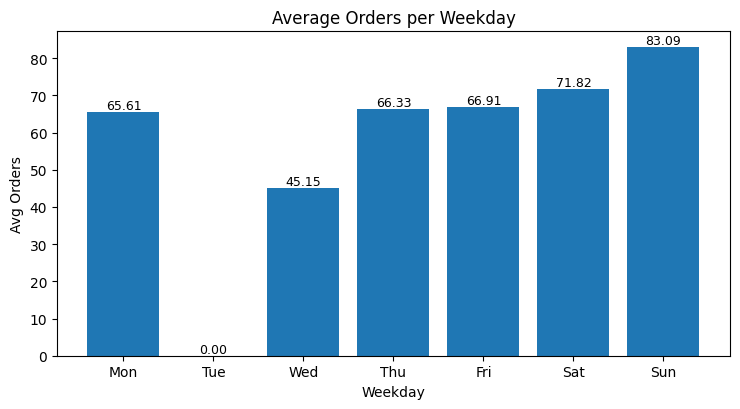


=== Average Order per Weekday ===
weekday  days  total_orders  avg_orders  total_revenue  avg_revenue
    Mon    23          1509       65.61     5381922.19    233996.62
    Tue     0             0        0.00           0.00         0.00
    Wed    20           903       45.15     2111810.29    105590.51
    Thu    18          1194       66.33     3715183.51    206399.08
    Fri    22          1472       66.91     4657213.45    211691.52
    Sat    22          1580       71.82     4773342.75    216970.12
    Sun    22          1828       83.09     6131142.97    278688.32

Insight:
- Puncak rata-rata order: **Sun** (83.09 order/hari).
- Terendah: **Tue** (0.00); selisih 83.09.
- Weekday vs Weekend: 48.80 vs 77.45 → weekend lebih tinggi.
- Saran: jadwalkan campaign/SDM ekstra di hari puncak; beri booster (voucher/ongkir) di hari lemah.


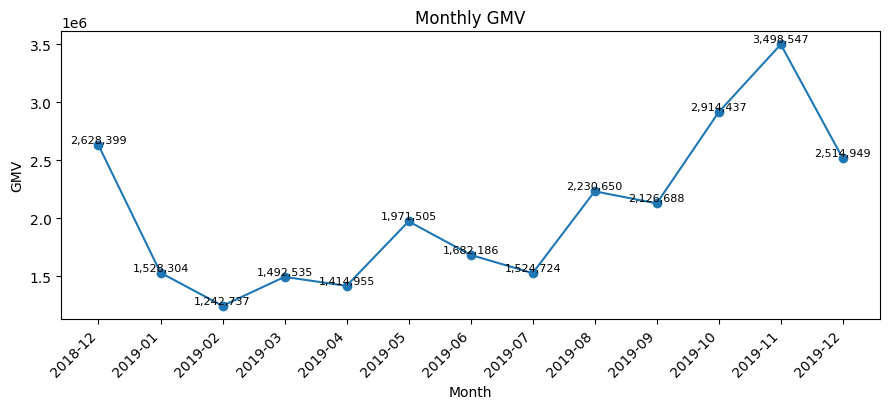


=== Monthly GMV / Orders / AOV / MoM(%) ===
 Period        GMV  Orders     AOV  GMV_MoM_%
2018-12 2628398.77     952 2760.92        NaN
2019-01 1528303.93     384 3979.96     -41.85
2019-02 1242737.11     436 2850.31     -18.69
2019-03 1492534.70     502 2973.18      20.10
2019-04 1414955.32     530 2669.73      -5.20
2019-05 1971504.88     710 2776.77      39.33
2019-06 1682185.62     611 2753.17     -14.68
2019-07 1524724.01     535 2849.95      -9.36
2019-08 2230649.80     559 3990.43      46.30
2019-09 2126688.14     657 3236.97      -4.66
2019-10 2914436.99     789 3693.84      37.04
2019-11 3498546.61    1004 3484.61      20.04
2019-12 2514949.28     817 3078.27     -28.11

Insight:
- Tren keseluruhan: menurun. Bulan GMV tertinggi: **2019-11** (GMV 3,498,547).
- Rata-rata AOV bulanan: 3,161; AOV tertinggi: 3,990.


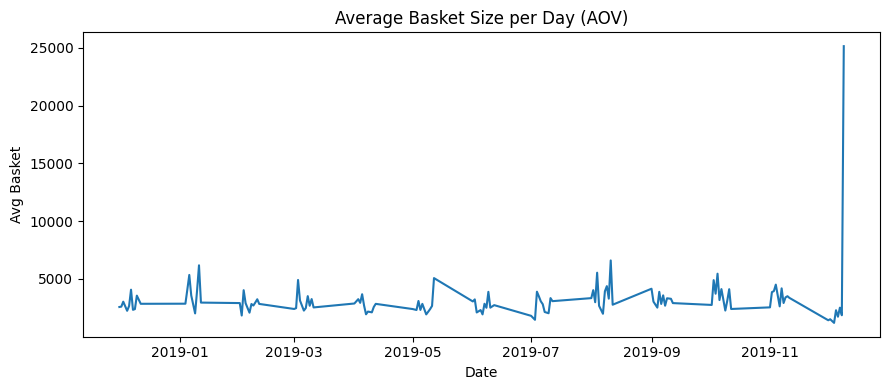


=== Daily AOV — Summary ===
Metric      AOV
 count   127.00
  mean  3213.91
   std  2176.54
   min  1198.69
   25%  2402.09
   50%  2858.50
   75%  3510.95
   90%  4135.87
   max 25137.95

Insight:
- Rata-rata harian: 3,214. Hari tertinggi: 2019-12-09 (AOV 25,138).
- Hari terendah: 2019-12-04 (AOV 1,199). Periksa event/promo & outlier.


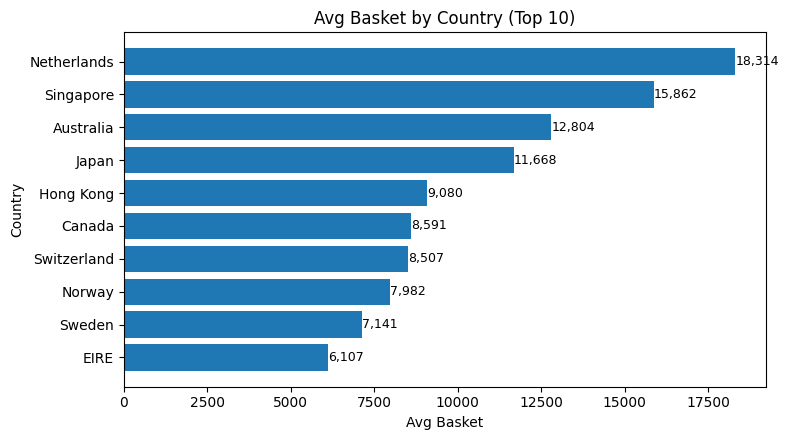


=== Avg/Median/P90 Basket by Country (Top) ===
    Country  Baskets  AvgBasket  MedianBasket      P90
Netherlands       36   18314.02       3690.73 61070.29
  Singapore        1   15862.38      15862.38 15862.38
  Australia       26   12803.81       2216.34 42686.33
      Japan        9   11667.96       2337.04 29423.60
  Hong Kong        1    9079.96       9079.96  9079.96
     Canada        2    8590.65       8590.65 10890.88
Switzerland       20    8507.24       2719.84 29858.91
     Norway       13    7982.40       1823.30 21488.76
     Sweden       14    7141.09       2078.14 25024.94
       EIRE      105    6107.21       3890.03 13275.58

Insight:
- Negara tertinggi: Netherlands (Avg 18,314); terendah (di daftar top): EIRE (Avg 6,107).
- Perbedaan terhadap rata-rata keseluruhan: 386.9%. Prioritaskan negara AOV tinggi untuk upsell/bundling.


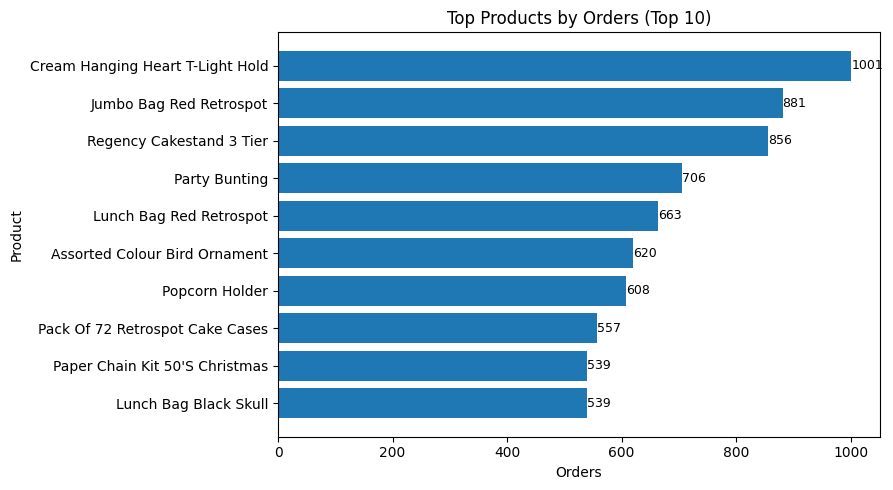


=== Top Products by Orders — Numbers ===
ProductNo                        ProductName  Orders  Quantity   Revenue
   85123A Cream Hanging Heart T-Light Holder    1001     17967 230669.90
   85099B            Jumbo Bag Red Retrospot     881     21495 131725.83
    22423           Regency Cakestand 3 Tier     856      6197 135963.11
    47566                      Party Bunting     706      7538 117508.23
    20725            Lunch Bag Red Retrospot     663      8462  51406.69
    84879      Assorted Colour Bird Ornament     620     18457 212002.65
    22197                     Popcorn Holder     608     24762 247612.43
    21212    Pack Of 72 Retrospot Cake Cases     557     14495 155393.90
    22086     Paper Chain Kit 50'S Christmas     539      9525 114899.26
    20727              Lunch Bag Black Skull     539      5198  31590.19

Insight:
- Top 10 menyumbang 5.3% dari total revenue. Amankan stok & aktifkan cross-sell/upsell pada item-item ini.


In [33]:
# ============================== JALANKAN YANG DIBUTUHKAN ==============================
weekday_orders_report(df)
monthly_gmv_report(df)
daily_aov_report(df)
country_aov_report(df, top=10)
top_products_report(df, top=10)
